In [1]:
import pandas as pd
import numpy as np
import math

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("rental_data.csv")
data

,Unnamed: 0,name,houseID,houseZip,rentAmount,paymentDate_clean,dob_clean,paymentAmount_clean
0,0,Paulina Lefort,1869,92129,1324.0,2010-01-02,NaN,1324.0
1,1,Clare Tilly,407,92155,1723.0,2010-01-02,NaN,1723.0
2,2,Eleni Loudin,647,92111,1494.0,2010-01-02,2000-01-01,1494.0
3,3,Tandy Ammann,2215,92153,1438.0,2010-01-02,1992-12-02,1438.0
4,4,Tamra Trisler,2213,92172,1658.0,2010-01-02,2000-01-01,1658.0
...,...,...,...,...,...,...,...,...
56605,56605,Kraig Lorusso,1279,92129,1338.0,2012-12-09,2000-01-01,1471.0
56606,56606,Ronna Messer,1967,92139,890.0,2012-12-09,2066-04-08,979.0
56607,56607,Wendell Blackmer,2417,92164,1688.0,2012-12-10,NaN,2110.0
56608,56608,Leandra Anstine,1358,92171,1559.0,2012-12-10,2000-01-01,1948.0


Data cleaning
PaymentAmount_clean: Replace negative values with 0:
Negative payment amount has no real-life meaning. We found that the -ve values are exactly -15% of the rent supposed to be paid, hence it might be some interest imposed. In this case, we assume that when these negative values occur, that means no payment is made in that particular month.
Replace empty cells in PaymentAmount column with 0:
Empty cells are replaced with zeros as we assume empty cells indicate no payment is made in that month

In [4]:
data.drop(columns = ["Unnamed: 0"], inplace = True) # Drop row number
data["paymentAmount_clean"].fillna(0, inplace=True) # Replace empty cells in payment_amount with zeros
data["paymentAmount_clean"][data["paymentAmount_clean"] < 0] = 0 # Replace all negative values with zeros

# Data preparation for analysis
Pleaes refer to comments for the explanations
DOB cleaning:
dob_clean attribute contains around 15k missing values. Apart from that, there are about 5k values do not have meaning in real life, e.g. tenant's birthday in the future, tenant who is 120 years old, tenant who is only a few years old who should not have the ability to rent a house. Therefore, we decided to replace invalid birth year data with 0 (i.e. discard dob information where age is less than 15 or greater than 100 at the time of rental. )

In [5]:
data["birthYear"] = data["dob_clean"].str[:4]
data.drop(columns = ["dob_clean"], inplace = True) # Drop row number
all_tenant = data[["name", "houseID"]].drop_duplicates()

In [6]:
dob_valid_records = pd.DataFrame(columns=data.columns)

for i in range(all_tenant.shape[0]):
    this_name = all_tenant.iloc[i,0]
    this_ID = all_tenant.iloc[i,1]
    
    this_frame = data[data["name"] == this_name]
    this_frame = this_frame[this_frame["houseID"] == this_ID]
    
    null_checker = pd.isnull(this_frame["birthYear"]).all()
    
    if null_checker:
        this_frame["birthYear"] = "0"
        dob_valid_records = dob_valid_records.append(this_frame)
    else:
        upper_year_checker = (this_frame["birthYear"]  > "1995").all()   # any ppl less than 15 yrs old
        lower_year_checker = (this_frame["birthYear"]  < "1910").all()   # any ppl larger than 100 yrs old
        
        if upper_year_checker or lower_year_checker:
            this_frame["birthYear"] = "0"
            dob_valid_records = dob_valid_records.append(this_frame)
        else:
            this_frame["birthYear"].fillna(this_frame["birthYear"].mode()[0], inplace = True)
            dob_valid_records = dob_valid_records.append(this_frame)

In [7]:
dob_valid_records["pmtDiff"] = dob_valid_records["paymentAmount_clean"] - dob_valid_records["rentAmount"] #Create a new attribute "pmtDiff" that calculates the difference between amount paid and rent by subtracting "rentAmount" from "paymentAmount"

dob_valid_records = dob_valid_records.groupby(["name", "birthYear", "houseID", "houseZip", "paymentDate_clean"]).sum() # In case a person makes payment more than once on the same day , we do a summation
dob_valid_records = dob_valid_records.reset_index()
all_dob_valid_tenant = dob_valid_records[["name", "houseID"]].drop_duplicates() # Create a skeleton with name and houseID as key

As each person might rent a few houses, and they might rent for a few years, to study the arrear situation in 12-month timeframe, our final output will have one record for each key (name and houseID) and during each rental year. To achieve this, we coded the below function.

This function creates a dataframe for each key within each 12 month timeframe. As rent agreement starts from the date a person rents a house instead of calendar year, the first 12 month is considered as the 1st year of rent and a time window is created for that. Same for the following years. For the last few months less than 12, that would be a new year as well. Within each time window, 'X's and 'Y' are calculated.


'X's:¶
name and ID: unique identifier
birthYear: Birth year of each tenant, assigned 0 if year is invalid
houseZip: houseZip contains info for house locations, and it is possible that people living in certain areas are more likely to make rental payments on time
aveRental: The rental price might associate with social class, which might be a factor that influence payment ability
avePayment: Capturing average monthly payments made by each tenant in a given year
aveDiff: aveRental - avePayment
max_stay: The num of month of stay in the same property might associate with the payment behavior
year: This year is not the exact year but the mode of year within that 12-month timeframe. This year factor helps associate the payment behavior with the general economic performance.
ith_year: ith year of stay for a tenant renting the same property, it would be interesting to see if association exists between the year of stay and the payment behavior

Y:
Risk flag generated according to rule: Within a 12-month timeframe, if a person has arrears for 1 or less month, the risk flag is assigned low; for 2-5 months, the risk flag is medium, and for >= 6 months, the risk flag is high

Hypothesis
Hypothesis: The Xs above are sufficient to estimate the Y. (i.e. the information contained in the transaction data is sufficient to correctly predict whether a tenant is a Low, Medium or High risk).

For this analysis we will support the Hypothesis if the accuracy of our predicted model is above 80%.

In order to test the above hypothesis, we will be using 3 different Machine Learning models in order to determine the risk profile of each tenant.

In [8]:
def tenant_process_by_year(df, time_window):
    
    num_chunks = math.ceil(df.shape[0]/time_window)
    ret = []
    
    ## Maxinum consecutive default count across all years 
    allCumDiff = this_frame["cumDiff"].to_list()
    allTimeMaxConsecArrears = getMaxLength(allCumDiff)
    
    for i in range(num_chunks):
        
        cur_df = df.iloc[i*time_window:(i+1)*time_window,:]    
        ## all X's
        name = cur_df["name"].unique()[0]
        birthYear = cur_df["birthYear"].mode()[0]
        ID = cur_df["houseID"].unique()[0]
        houseZip = cur_df["houseZip"].unique()[0]
        aveRental = cur_df["rentAmount"].mean()
        avePayment = cur_df["paymentAmount_clean"].mean()
        max_stay = cur_df["stayDur"].max()
        year = cur_df["paymentDate_clean"].str.slice(stop=4).mode()[0]
        ith_year = i+1
        aveDiff = avePayment - aveRental
        
        ## maximum consecutive default count within the time window (1-year)
        cumDiff = cur_df["pmtDiff"].cumsum().to_list()
        oneYearMaxConsecArrears = getMaxLength(cumDiff)
        
        ## All occurance of default within the time window (1-year)
        oneYearAllArrears = sum([1 for i in cumDiff if i <0])

        this_ret = [name, birthYear, ID, houseZip, max_stay, year, ith_year, aveRental, avePayment, aveDiff, oneYearMaxConsecArrears, oneYearAllArrears,
                   allTimeMaxConsecArrears]
        ret.append(this_ret)
    
    return ret

This helper function generates the maximum number of consecutive month with negative cumDiff, once the arrear is paid back, the count is set back to 0.

In [10]:
def getMaxLength(ls):
    # initialize count
    count = 0
     
    # initialize max
    result = 0
 
    for i in range(len(ls)):
     
        # Reset count when 0 is found
        if (ls[i] >= 0):
            count = 0
 
        else:
             
            # increase count
            count+= 1
            result = max(result, count)        
    return result

Append the aggregated x and y into the pre-defined skeleton.

In [12]:
total = []
for i in range(all_dob_valid_tenant.shape[0]):
    this_name = all_dob_valid_tenant.iloc[i,0]
    this_ID = all_dob_valid_tenant.iloc[i,1]
    
    this_frame = dob_valid_records[dob_valid_records["name"] == this_name]
    this_frame = this_frame[this_frame["houseID"] == this_ID]
    
    this_frame["stayDur"] = np.arange(this_frame.shape[0]) + 1
    this_frame["cumDiff"] = this_frame["pmtDiff"].cumsum()
        
    this_record = tenant_process_by_year(this_frame, 12) 
    
    for i in this_record:
        total.append(i)

In [13]:
df = pd.DataFrame(total, columns = ["name", "birthYear","ID", "houseZip", "max_stay", "year", "ith_year", "aveRental", "avePayment",
                                    "aveDiff" ,"oneYearMaxConsecArrears", "oneYearAllArrears","allTimeMaxConsecArrears"])

In [14]:
df["risk"] = ["High" if i >= 6  else ("Medium" if i >= 2 else "Low") for i in df["oneYearMaxConsecArrears"]]

In [15]:
df

,name,birthYear,ID,houseZip,max_stay,year,ith_year,aveRental,avePayment,aveDiff,oneYearMaxConsecArrears,oneYearAllArrears,allTimeMaxConsecArrears,risk
0,Aaron Huston,0,1,92194,12,2010,1,1720.0,1720.000000,0.000000,0,0,0,Low
1,Aaron Huston,0,1,92194,24,2011,2,1720.0,1720.000000,0.000000,0,0,0,Low
2,Aaron Huston,0,1,92194,31,2012,3,1720.0,1720.000000,0.000000,0,0,0,Low
3,Abbey Kluth,0,2,92198,12,2010,1,1619.0,1834.250000,215.250000,0,0,0,Low
4,Abbey Kluth,0,2,92198,24,2011,2,1619.0,1834.166667,215.166667,0,0,0,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5915,Zola Howley,1984,2474,92102,12,2011,1,1021.0,1021.000000,0.000000,0,0,6,Low
5916,Zola Howley,1984,2474,92102,18,2012,2,1021.0,850.833333,-170.166667,6,6,6,High
5917,Zona Thorton,0,2475,92124,12,2010,1,1661.0,1661.000000,0.000000,0,0,0,Low
5918,Zona Thorton,0,2475,92124,24,2011,2,1661.0,1661.000000,0.000000,0,0,0,Low


In [16]:
df.to_csv("Processed Data for Machine Learning.csv", index = False)

# Data exploration

Text(0.5, 1.0, 'Correlation Heatmap')

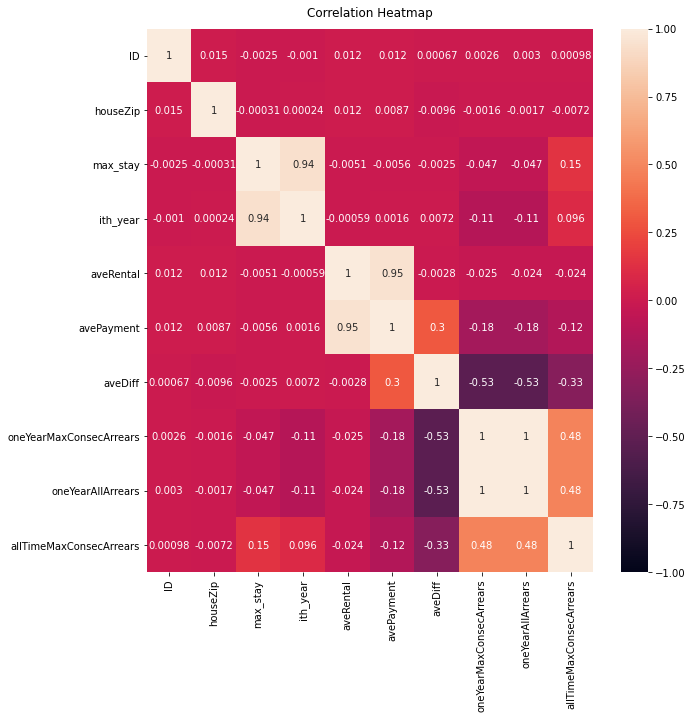

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

df.corr()
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12},pad=12)

It is important to note that correlation between variable does not indicate causation. There are two major observations from the above correlation plot

High correlation between max_stay and ith-year variable, which is because for i-th year = 1, max_stay is usually calculated to be 12 months, and for i-th year = 2, max_stay is usually calculated to be 24 months. Considering the high correlation, we remove the max_stay variable from our model.
We observe high correlation between aveRental and avePayment since each tenant will need to pay more if the rental amount due is higher. Therefore, we remove avePayment column to reduce multicollinearity.
oneYearMaxConsecArrears is highly correlated with oneYearAllArrears, therefore we will drop oneYearAllArrears and only keep oneYearMaxConsecArrears as the basis of risk flag assignment (Y) in the model, which will also not be included as X in later model training.
allTimeMaxConsecArrears are maximum default series for a tenant across the whole rental period, which can imply the long-term risk of a tenant. However, as we're building a model with data records for each tenant for each year, we decided not to include this variable as our Y.
New correlation plot is shown as below, as we can see, multicollinearity issue is now fixed.

Text(0.5, 1.0, 'Correlation Heatmap')

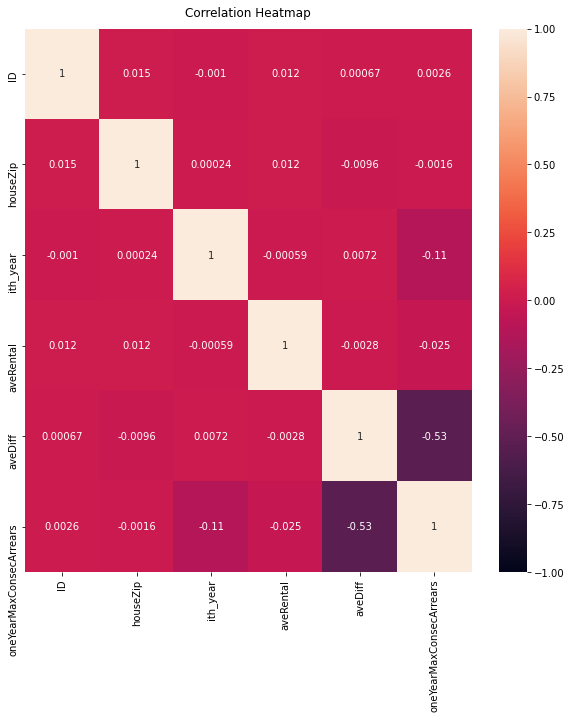

In [18]:
df.drop(columns = ['avePayment','max_stay', 'oneYearAllArrears', 'allTimeMaxConsecArrears'], inplace = True)
df.corr()
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12},pad=12)

# Model training

In [20]:
columns = ['birthYear','houseZip','year','ith_year','aveRental', 'aveDiff','risk']
from sklearn.model_selection import train_test_split
y = df['risk']
features = columns[:-1]
X = df[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 3)

Decision Tree
(a) Train the model and calculate accuracy


In [22]:
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

#We use Entropy instead of Gini index as splitting criteria and limit depth of tree to reduce overfitting
clf_1 = DecisionTreeClassifier(criterion="entropy", max_depth=5)
#Train Decision Tree Classifer
clf_1 = clf_1.fit(X_train,y_train)

#Predict the response for test dataset 

y_pred = clf_1.predict(X_test)

tree_accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
print("Accuracy:",tree_accuracy)

              precision    recall  f1-score   support

        High       0.57      0.88      0.69       158
         Low       0.99      0.98      0.99      1490
      Medium       0.58      0.26      0.36       128

    accuracy                           0.92      1776
   macro avg       0.72      0.71      0.68      1776
weighted avg       0.92      0.92      0.92      1776

Accuracy: 0.9217342342342343


(b) Tree visualization

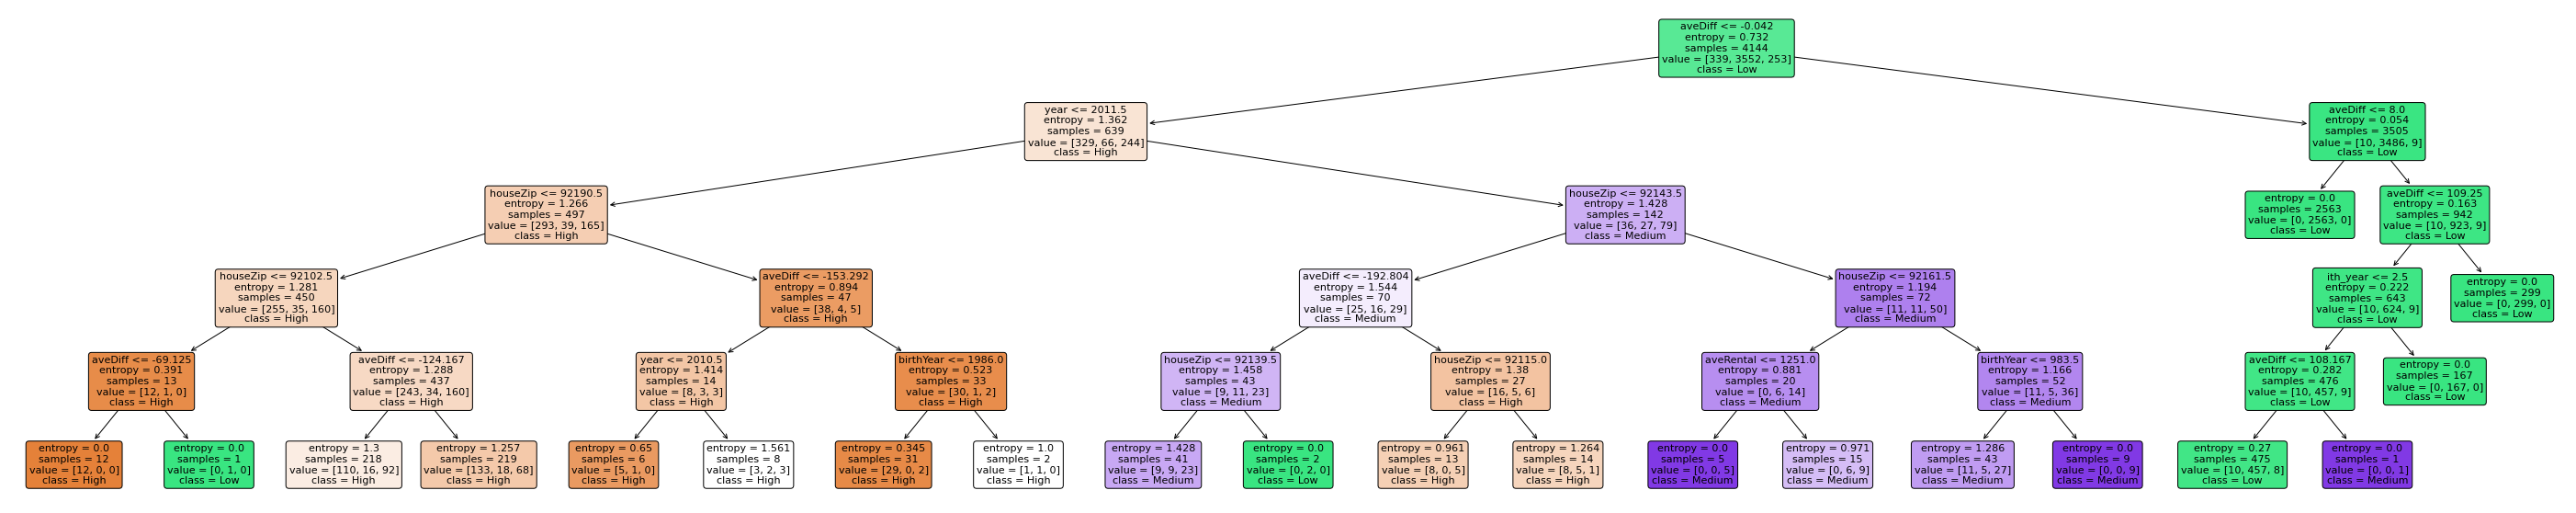

In [24]:
fig = plt.figure(figsize=(50,10))
plot_tree(clf_1, feature_names=features, class_names=['High', 'Low', 'Medium'], filled=True, rounded=True, ax=plt.gca())
plt.show()

(c) Feature Importance¶

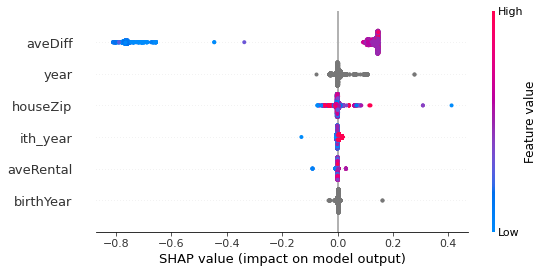

In [28]:
import shap

# define the explainer
explainer = shap.TreeExplainer(clf_1)
# calculate the shape value
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[1], X_train)

Based on above plot, aveDiff, year and houseZip are three most important features in the tree model.

KNN Model
(a) Normalization

In [29]:
## To have more accurate results from KNN model, we decide to first normalize 'aveRental' and 'aveDiff'

from sklearn.preprocessing import Normalizer
X_train_to_normalize = X_train[['aveRental', 'aveDiff']]
X_test_to_normalize = X_test[['aveRental', 'aveDiff']]
normalizer = Normalizer()
normalizer.fit(X_train_to_normalize)
X_train_normalized = normalizer.transform(X_train_to_normalize)
X_test_normalized = normalizer.transform(X_test_to_normalize)

In [30]:
X_train_norm = np.concatenate((X_train.iloc[:,[0,1,2,3]], X_train_normalized), axis=1)
X_test_norm = np.concatenate((X_test.iloc[:,[0,1,2,3]], X_test_normalized), axis=1)

In [31]:
X_train_norm = pd.DataFrame(X_train_norm, columns = ["birthYear","houseZip", "year", "ith_year", "aveRental_norm","aveDiff_norm"])
X_test_norm = pd.DataFrame(X_test_norm, columns = ["birthYear","houseZip", "year", "ith_year", "aveRental_norm","aveDiff_norm"])

(b) Determine the K value of KNN model
In order to have the best accuracy using the kNN ML algo, we must first determine the k. Let us find the k with the lowest error

Text(0, 0.5, 'Mean Error')

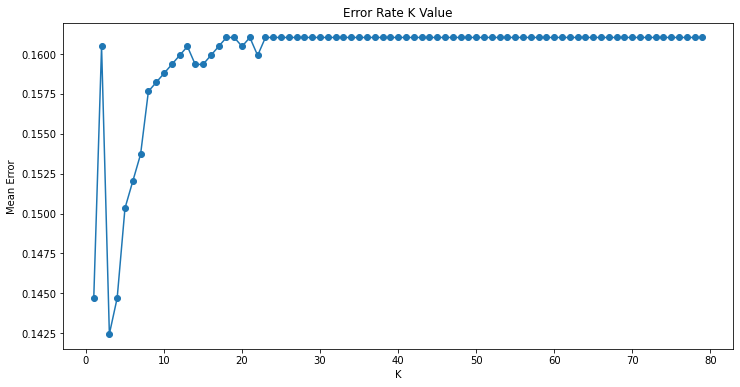

In [32]:
kerror = []
from sklearn.neighbors import KNeighborsClassifier

for i in range(1, 80):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_norm, y_train)
    pred_i = knn.predict(X_test_norm)
    kerror.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(12, 6))
plt.plot(range(1, 80), kerror, marker='o')
plt.title('Error Rate K Value')
plt.xlabel('K')
plt.ylabel('Mean Error')

In [33]:
### Find the K with minumum error rate
mink = 100
minklocation = 0
for index, x in enumerate(kerror):
    if x<mink:
        mink=x
        minklocation = index
print(minklocation+1)

3


From the below observations, it seems that we should use the k value of 3.

#### (c) Training and predicitions

In [35]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train_norm, y_train)
y_pred = classifier.predict(X_test_norm)
print(classification_report(y_test, y_pred))

KNN_accuracy_norm = accuracy_score(y_test, y_pred)

print("Accuracy:",KNN_accuracy_norm)

              precision    recall  f1-score   support

        High       0.44      0.35      0.39       158
         Low       0.90      0.98      0.94      1490
      Medium       0.20      0.04      0.07       128

    accuracy                           0.86      1776
   macro avg       0.51      0.46      0.47      1776
weighted avg       0.81      0.86      0.83      1776

Accuracy: 0.857545045045045


If we do not normalize the X inputs:¶

Text(0, 0.5, 'Mean Error')

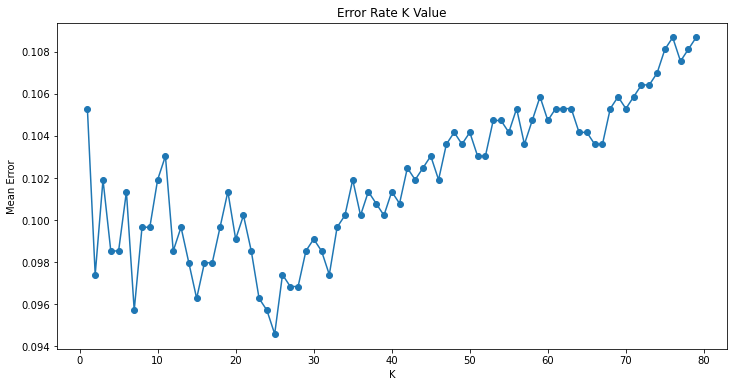

In [36]:
kerror = []
from sklearn.neighbors import KNeighborsClassifier

for i in range(1, 80):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    kerror.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(12, 6))
plt.plot(range(1, 80), kerror, marker='o')
plt.title('Error Rate K Value')
plt.xlabel('K')
plt.ylabel('Mean Error')

In [37]:
### Find the K with minumum error rate
mink = 100
minklocation = 0
for index, x in enumerate(kerror):
    if x<mink:
        mink=x
        minklocation = index
print(minklocation+1)

25


In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

classifier = KNeighborsClassifier(n_neighbors=25)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

KNN_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:",KNN_accuracy)

              precision    recall  f1-score   support

        High       0.55      0.72      0.62       158
         Low       0.97      0.99      0.98      1490
      Medium       0.44      0.20      0.28       128

    accuracy                           0.91      1776
   macro avg       0.65      0.64      0.63      1776
weighted avg       0.90      0.91      0.90      1776

Accuracy: 0.9054054054054054


In [39]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

     |████████████████████████████████| 216 kB 943 kB/s eta 0:00:01
     |████████████████████████████████| 47 kB 1.1 MB/s eta 0:00:01
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107729 sha256=2d01b797aec33a9aeb77eb198769f8df21acd25dfad72b1842e16390f0242130
  Stored in directory: /Users/andhika/Library/Caches/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5


### (d) Feature importance

In [41]:
# define a permutation importance object
perm = PermutationImportance(classifier).fit(X_train, y_train)
# show the importance
eli5.show_weights(perm, feature_names=["birthYear","houseZip", "year", "ith_year", "aveRental","aveDiff"])

Weight,Feature
0.1620 ± 0.0037,aveDiff
0.0080 ± 0.0063,aveRental
0.0024 ± 0.0019,houseZip
0 ± 0.0000,ith_year
0 ± 0.0000,year
-0.0011 ± 0.0025,birthYear


Based on above statistics, aveDiff, aveRental and houseZip are the three more important features in the KNN model, of which aveDiff is highly influential and houseZip is only marginally influential.

Logistics Regression Model
（a) Training and testing
Since logistics regression is more suitable for binary classification, we reassigned risk flags as below to categorize long-term arrears risk

For "risk" = high, assign new risk flag = 1, meaning it has long-term arrears risk (over 6 months)
For "risk" = medium / low, assign new risk flag = 0, meaning it has only short-term arrears risk.
Therefore, using this model, we can also differentiate short-term and long-term arrears risk.

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


y_train_logit = []
for y in y_train:
    if y == 'Low':
        y_train_logit.append(0)
    if y == 'Medium':
        y_train_logit.append(0)
    if y == 'High':
        y_train_logit.append(1)

y_test_logit = []
for y in y_test:
    if y == 'Low':
        y_test_logit.append(0)
    if y == 'Medium':
        y_test_logit.append(0)
    if y == 'High':
        y_test_logit.append(1)       
        
clf = LogisticRegression(random_state=0).fit(X_train, y_train_logit)
clf.predict(X_test)
score = clf.score(X_test, y_test_logit)
y_pred = clf.predict(X_test)

Logistics_accuracy = clf.score(X_test,y_test_logit)

print(score)
print("Training set score: {:.3f}".format(clf.score(X_train,y_train_logit)))
print("Test set score: {:.3f}".format(Logistics_accuracy))
print(classification_report(y_test_logit, y_pred))

0.9059684684684685
Training set score: 0.908
Test set score: 0.906
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1618
           1       0.43      0.16      0.24       158

    accuracy                           0.91      1776
   macro avg       0.67      0.57      0.59      1776
weighted avg       0.88      0.91      0.89      1776



In [44]:
cnf_matrix = metrics.confusion_matrix(y_test_logit, y_pred)
cnf_matrix

array([[1583,   35],
       [ 132,   26]])

(b) Feature importance

In [45]:
# define a permutation importance object
perm = PermutationImportance(clf).fit(X_train, y_train_logit)
# show the importance
eli5.show_weights(perm, feature_names=["birthYear","houseZip", "year", "ith_year", "aveRental","aveDiff"])

Weight,Feature
0.0152 ± 0.0048,aveDiff
0 ± 0.0000,ith_year
0 ± 0.0000,year
0 ± 0.0000,houseZip
-0.0005 ± 0.0002,birthYear
-0.0020 ± 0.0013,aveRental


Therefore using logistics model, only aveDiff feature is considered important to classification.

Model Comparison

In [46]:
accuracy = pd.DataFrame(columns = ["Model", "accuracy"], data = [["Decision Tree",tree_accuracy],["KNN",KNN_accuracy],["Logistics Regression",Logistics_accuracy]])
accuracy

,Model,accuracy
0,Decision Tree,0.921734
1,KNN,0.905405
2,Logistics Regression,0.905968


Hypothesis Conclusion
We support our null hypothesis, as all our machine learning models obtain an accuracy above 80%. However we will select the Decision Tree model in order to classify the risk profile of the tenants - as it has the highest accuracy.

Scorecard
Since Decision Tree model yield the best accuracy and precision for all risk levels, we decided to adopt the Decision Tree model to produce a scorecard for each tenant based on our model prediction. Other advantages of using a decision tree classifier includes that it does not require scaling; so, there is no risk of losing important features. In addition, it is easy to draw insight and conclusions from them by comparing the split of each node e.g. the 'aveDiff' node can provide the boundaries for when a tenant is more likely to be classified as 'high' risk or not. However, there are some limitations to this model as some inputs may seem counter-intuitive in the tree visualization such as 'houseZip' because it has no numerical value.

In the Scorecard, we assigned "3" for "low risk", "6" for "medium risk" and "9" for "high risk", and then we take the average of the predicted risk scores for each tenant with unique house ID (In our clean data, each record is within a 12 month timeframe, if a person stayed for 3 years, there would be 3 records, and the final score card is the average of the 3 risk scores).

In [47]:
y_pred_all = clf_1.predict(X)
df['predicted results'] = y_pred_all
df["risk score"] = [3 if i == "Low"  else (6 if i == "Medium" else 9) for i in df["predicted results"]]
df

,name,birthYear,ID,houseZip,year,ith_year,aveRental,aveDiff,oneYearMaxConsecArrears,risk,predicted results,risk score
0,Aaron Huston,0,1,92194,2010,1,1720.0,0.000000,0,Low,Low,3
1,Aaron Huston,0,1,92194,2011,2,1720.0,0.000000,0,Low,Low,3
2,Aaron Huston,0,1,92194,2012,3,1720.0,0.000000,0,Low,Low,3
3,Abbey Kluth,0,2,92198,2010,1,1619.0,215.250000,0,Low,Low,3
4,Abbey Kluth,0,2,92198,2011,2,1619.0,215.166667,0,Low,Low,3
...,...,...,...,...,...,...,...,...,...,...,...,...
5915,Zola Howley,1984,2474,92102,2011,1,1021.0,0.000000,0,Low,Low,3
5916,Zola Howley,1984,2474,92102,2012,2,1021.0,-170.166667,6,High,High,9
5917,Zona Thorton,0,2475,92124,2010,1,1661.0,0.000000,0,Low,Low,3
5918,Zona Thorton,0,2475,92124,2011,2,1661.0,0.000000,0,Low,Low,3


In [48]:
df = df.groupby(["name", "ID"])["risk score"].mean()
df.reset_index()

,name,ID,risk score
0,Aaron Huston,1,3.0
1,Abbey Kluth,2,3.0
2,Abe Prophet,4,5.0
3,Abel Emmett,3,3.0
4,Abraham Maggi,5,3.0
...,...,...,...
2465,Zoila Buth,2471,3.0
2466,Zoila Faler,2472,3.0
2467,Zola Howley,2473,3.0
2468,Zola Howley,2474,6.0


Business Analytics Discussion
The above models would help us determine which tenants are most likely to fall into arrears. By using the Machine Learning models above and predicting the risk level of each tenant, the association would be able to put preemptive measures in place in order to mitigate some of the costs associated with medium/high risk tenants.

Given the cost of high risk tenants is 10 times higher than those of low risk tenants, associations should focus on preventing tenants into falling in long-term arrears. Potential measures could be put in place such as the following:

Targeted Incentive Programs: In Zip codes where tenants are more likely to fall into arrears, the association could offer a small discount to those who pay their rent on time.

Taking out a renters insurance in order to protect themselves in the situations where tenants are unable to pay rent for an extended period of time.

Consider whether they should limit the number of tenants they have in 'high risk Zip codes'. In order to mitigate associated cost.

A strong emphasis should also be placed on medium risk tenants, as they are the individuals at risk of becoming high risk tenants if they continue to not pay rent.

In an ideal scenario, the housing association would only have low risk tenants, however in the real world, that is not the case. Although, the association should be focusing on preemptive measures to mitigate the number of medium & high-risk tenants - it should still monitor low risk tenants to ensure that they do not fall into short-term arrears. Further analysis could be done in order to find Zip codes where low risk tenants tend to fall into short-term arrears for short periods of time. The association could look to support those individuals, to ensure that the arrears period does not last.

In addition to the above measure, the associated could look into providing counselling services or hotlines available to all tenants (perhaps starting off in Zip codes where individuals tend to fall into the medium & high-risk bracket). The upfront cost of hiring counsellors could save them money in the long term by aiming to help tenants at risk of falling into debt.

The association could focus on services on teaching tenants how to pay off existing debt, financial literacy/education courses and also mental health. The support provided to the medium to high-risk tenants could have a positive impact and stir them away from falling into long-term arrears.

Limitation of the Analysis
When looking closely, it seems that our models seem to correctly predict the low-risk tenants but have a slightly above 50% accuracy in predicting medium and high risk profile tenants (this accuracy is only slightly better than a random chance classification). Given the latter two are the most important risk profiles to determine accurately, we must look to increase accuracy of those risk profiles.

Our models are better at predicting low risk profiles because our data is slightly skewed and has more low risk tenants than medium and high-risk tenants. This is a classic data imbalance issue, creating models that are better at predicting for a class with more datasets. In order to fix this issue, we could perform some data rebalancing in order to ensure that the number of low, medium and high-risk tenants are the same.

In order to create more robust models and hope to increase accuracy of our med/high risk profiles, we would have additional information such as a tenant's credit score, whether they have a guarantor, their yearly income and other social-economic statuses which could influence the likelihood of them falling into arrears.